<a href="https://colab.research.google.com/github/aksevenli/Pytorch-Reinforcement-Learning/blob/master/hillClimbingAlgorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Developing the hill-climbing algorithm
As we can see in the random search policy, each episode is independent. In fact, all episodes in random search can be run in parallel, and the weight that achieves the best performance will eventually be selected. We've also verified this with the plot of reward versus episode, where there is no upward trend. In this recipe, we will develop a different algorithm, a hill-climbing algorithm, to transfer the knowledge acquired in one episode to the next episode.

In the hill-climbing algorithm, we also start with a randomly chosen weight. But here, **for every episode, we add some noise to the weight**. **If the total reward improves, we update the weight with the new one**; otherwise, we keep the old weight. In this approach, the weight is gradually improved as we progress through the episodes, instead of jumping around in each episode.

In [0]:
import gym
import torch

In [0]:
env = gym.make('CartPole-v0')
n_state = env.observation_space.shape[0]
n_action = env.action_space.n

def run_episode(env, weight):
    state = env.reset()
    total_reward = 0
    is_done = False

    while not is_done:
        state = torch.from_numpy(state).float()
        action = torch.argmax(torch.matmul(state, weight))
        state, reward, is_done, _ = env.step(action.item())
        total_reward += reward
    return total_reward

In [2]:
n_episode = 1000
best_total_reward = 0
best_weight = torch.rand(n_state, n_action)
total_rewards = []

# Add some noise to the weight for each episode
# Apply a scale to the noise so that the noise won't overwhelm the weight
noise_scale = 0.01

NameError: ignored

After we randomly pick an initial weight, for each episode, we do the following:


*   Add random noise to the weight
*   Let the agent take actions according to the linear mapping
*   An episode terminates and returns the total reward
*   If the current reward is greater than the best one obtained so far, update the best reward and the weight
*   Otherwise, the best reward and the weight remain unchanged
*   Also, keep a record of the total reward

In [0]:
for episode in range(n_episode):
    weight = best_weight + noise_scale * torch.rand(n_state, n_action)
    total_reward = run_episode(env, weight)
    if total_reward >= best_total_reward:
        best_weight = best_weight
    total_rewards.append(total_reward)
    print('Episode {}: {}'.format(episode + 1, total_reward))
print('Average total reward over {} episode: {}'.format(n_episode, sum(total_rewards) / n_episode))  

To assess the training using the hill-climbing algorithm, we repeat the training process multiple times. We observe that the average total reward fluctuates a lot. What could cause such variance? **It turns out that if the initial weight is bad, adding noise at a small scale will have little effect on improving the performance**. This will cause **poor convergence**. On the other hand, if the initial weight is good, adding noise at a big scale might move the weight away from the optimal weight and jeopardize the performance. How can we make the training of the hillclimbing model more stable and reliable? We can actually make the noise scale adaptive to the performance, just like the adaptive learning rate in gradient descent.
To make the noise adaptive, we do the following:


*   Specify a starting noise scale.
*   If the performance in an episode **improves**, **decrease** the noise scale. In our case, we take half of the scale, but set **0.0001** as the lower bound.
*   If the performance in an episode **drops**, **increase** the noise scale. In our case, we double the scale, but set **2** as the upper bound.



In [0]:
noise_scale = 0.01
best_total_reward = 0
total_rewards = []
for episode in range(n_episode):
    weight = best_weight + noise_scale * torch.rand(n_state, n_action)
    total_reward = run_episode(env, weight)
    if total_reward >= best_total_reward:
        best_total_reward = total_reward
        best_weight = weight
        noise_scale = max(noise_scale / 2, 1e-4)
    else:
        noise_scale = min(noise_scale * 2, 2)
    print('Episode {}: {}'.format(episode + 1, total_reward))
    total_rewards.append(total_reward)


In [11]:
print('Average total reward over {} episode: {}'.format(n_episode, sum(total_rewards) / n_episode))

Average total reward over 1000 episode: 196.679


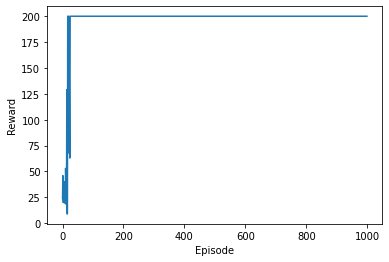

In [12]:
import matplotlib.pyplot as plt
plt.plot(total_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In the resulting plot, we can see a clear upward trend before it plateaus at the maximum value

Now, let's see how the learned policy performs on 100 new episodes:

In [13]:
n_episode_eval = 100
total_rewards_eval = []
for episode in range(n_episode_eval):
    total_reward = run_episode(env, best_weight)
    print('Episode {}: {}'.format(episode+1, total_reward))
    total_rewards_eval.append(total_reward)

Episode 1: 200.0
Episode 2: 200.0
Episode 3: 200.0
Episode 4: 200.0
Episode 5: 200.0
Episode 6: 200.0
Episode 7: 200.0
Episode 8: 200.0
Episode 9: 200.0
Episode 10: 200.0
Episode 11: 200.0
Episode 12: 200.0
Episode 13: 200.0
Episode 14: 200.0
Episode 15: 200.0
Episode 16: 200.0
Episode 17: 200.0
Episode 18: 200.0
Episode 19: 200.0
Episode 20: 200.0
Episode 21: 200.0
Episode 22: 200.0
Episode 23: 200.0
Episode 24: 200.0
Episode 25: 200.0
Episode 26: 200.0
Episode 27: 200.0
Episode 28: 200.0
Episode 29: 200.0
Episode 30: 200.0
Episode 31: 200.0
Episode 32: 200.0
Episode 33: 200.0
Episode 34: 200.0
Episode 35: 200.0
Episode 36: 200.0
Episode 37: 200.0
Episode 38: 200.0
Episode 39: 200.0
Episode 40: 200.0
Episode 41: 200.0
Episode 42: 200.0
Episode 43: 200.0
Episode 44: 200.0
Episode 45: 200.0
Episode 46: 200.0
Episode 47: 200.0
Episode 48: 200.0
Episode 49: 200.0
Episode 50: 200.0
Episode 51: 200.0
Episode 52: 200.0
Episode 53: 200.0
Episode 54: 200.0
Episode 55: 200.0
Episode 56: 200.0
E

In [14]:
print('Average total reward over {} episode: {}'.format(n_episode, sum(total_rewards) / n_episode))

Average total reward over 1000 episode: 196.679


The average reward for the testing episodes is close to the maximum of 200 that we obtained with the learned policy. You can re-run the evaluation multiple times. The results are pretty consistent.

We are able to achieve much better performance with the hill-climbing algorithm than with random search by simply **adding adaptive noise** to each episode. We can think of it as a special kind of gradient descent without a target variable. The additional noise is the gradient, albeit in a random way. **The noise scale is the learning rate**, and it is adaptive to the reward from the previous episode. The target variable in hill climbing becomes achieving the highest reward. In summary, rather than isolating each episode, the agent in
the hill-climbing algorithm makes use of the knowledge learned from each episode and performs a more reliable action in the next episode. As the name hill climbing implies, the reward moves upwards through the episodes as the weight gradually moves towards the optimum value.

We can observe that the reward can reach the maximum value within the first 100 episodes. Can we just stop training when the reward reaches 200, as we did with the random search policy? That might not be a good idea. Remember that the agent is making continuous improvements in hill climbing. Even if it finds a weight that generates the maximum reward, it can still search around this weight for the optimal point. Here, we define the optimal policy as the one that can solve the CartPole problem. According to the following wiki page, https:/​/​github.​com/​openai/​gym/​wiki/​CartPole-​v0, "solved" means the average reward over 100 consecutive episodes is no less than 195.

In [3]:
noise_scale = 0.01
best_total_reward = 0
total_rewards = []

for episode in range(n_episode):
    weight = best_weight + noise_scale * torch.rand(n_state, n_action)
    total_reward = run_episode(env, weight)
    if total_reward >= best_total_reward:
        best_total_reward = total_reward
        best_weight = weight
        noise_scale = max(noise_scale / 2, 1e-4)
    else:
        noise_scale = min(noise_scale * 2, 2)
    print('Episode {}: {}'.format(episode + 1, total_reward))
    total_rewards.append(total_reward)
    if episode >= 99 and sum(total_rewards[-100:]) >= 19500:
        break

NameError: ignored